# Новый Python интерфейс BigARTM.

## Пример №1

Здесь приводится простой пример использования нового пользовательского интерфейса на Python библиотеки BigARTM. Мы будем обучать тематическую модель маленькой коллекции 'kos'.
Для начала подключим все необходимые модули (убедитесь, что путь к model.py находится в вашей переменной PATH):

In [1]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt

import artm

Первым делом содадим тематическую модель. Новый интерфейс позволяет сделать это в одну строчку:

In [2]:
model = artm.ArtmModel(num_topics=15)

ArtmModel — это объект, содержащий в себе всю информацию о текущем состоянии тематической модели. Все наши последующие действия будут производиться в рамках него. Прежде всего распарсим из файлов 'docword' и 'vocab' в формате UCI, если это необходимо:

In [3]:
if len(glob.glob('kos' + "/*.batch")) < 1:
    artm.parse(data_path='', data_format='bow_uci', collection_name='kos')

Следующий шаг — инициализация модели. Сделаем это по словарю, что означает, что
- будет создана матрица Фи с именем 'pwt', число строк и столбцов в ней будет взято исходя из числа слов в словаре и заданного в модели числа тем;
- эа матрица будет заполнена случайными значениями из диапазона (0, 1) и нормализована.

Надо отметить, что этот шаг является опциональным, поскольку модель может быть автоматически инициализирована во время вызовов fit_offline() / fit_online().

In [4]:
model.load_dictionary(dictionary_name='dictionary', dictionary_path='kos/dictionary')
model.initialize(dictionary_name='dictionary')

ArtmModel предоставляет возможность использовать все функционалы качества, имеющиеся в BigARTM. Если функционал подключен к модели, то модель будет сохранять все его значения, полученные на момент каждого обновления матрицы Фи.
Для контроля за качеством получаемой модели введём несколько метрик:

In [5]:
model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(artm.PerplexityScore(name='PerplexityScore'))

Также полезно добавить несколько базовых регуляризаторов, повышающих разреженность и различность тем (зададим им стартовые коэффициенты регуляризации, которые можно будет позже изменить)

In [6]:
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-2.0))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=100000.0))

Теперь попробуем обучить модель в оффлайн-режиме (т.е. обновляя Фи раз за проход по коллекции). Инициируем пять проходов:

In [7]:
model.fit_offline(data_path='kos', num_collection_passes=5)

Проверим результаты первой итерации обучения:

In [8]:
print 'Sparsity Phi:' + str(model.scores_info['SparsityPhiScore'].last_value)
print 'Sparsity Theta:' + str(model.scores_info['SparsityThetaScore'].last_value)

Sparsity Phi:0.425060334009
Sparsity Theta:0.699183673469


Видно, что разреженности матриц пока ещё слишком невелики. Попробуем увеличить по модулю значения коэффициентов регуляризации при разреживающих регуляризаторах:

In [9]:
model.regularizers['SparsePhi'].tau = -0.4
model.regularizers['SparseTheta'].tau = -3.0

Также полезно добавить функционал 'TopTokensScore'. Он позволит нам увидеть самые вероятные слова в каждой полученной теме

In [10]:
model.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=5))

Продолжим обучение модели, инициировав 15 проходов по коллекции:

In [11]:
model.fit_offline(data_path='kos', num_collection_passes=15)

In [12]:
print 'Sparsity Phi:' + str(model.scores_info['SparsityPhiScore'].last_value)
print 'Sparsity Theta:' + str(model.scores_info['SparsityThetaScore'].last_value)

Sparsity Phi:0.638024905879
Sparsity Theta:0.793756073858


Разреженность всё ещё неудовлетворительная. Попробуем ещё усилить разреживание и продолжить обучение:

In [13]:
model.regularizers['SparsePhi'].tau = -1.5
model.regularizers['SparseTheta'].tau = -5.0
model.fit_offline(data_path='kos', num_collection_passes=15)

Нарисуем графики перплексии и разреженностей:

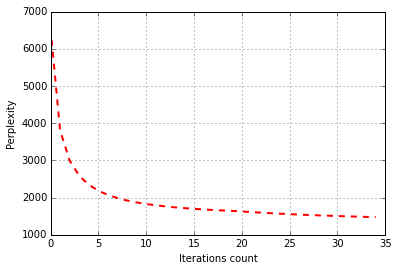

In [14]:
plt.plot(xrange(model.num_phi_updates), model.scores_info['PerplexityScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('Perplexity')
plt.grid(True)
plt.show()

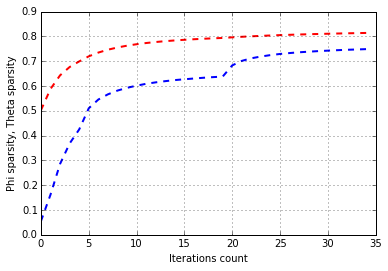

In [15]:
plt.plot(xrange(model.num_phi_updates), model.scores_info['SparsityPhiScore'].value, 'b--',
         xrange(model.num_phi_updates), model.scores_info['SparsityThetaScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('Phi sparsity, Theta sparsity')
plt.grid(True)
plt.show()

Для столь маленькой коллекции разреженность достаточная. Напечатаем топовые слова в каждой теме:

In [16]:
for topic_name in model.topic_names:
    print topic_name + ': ',
    print model.scores_info['TopTokensScore'].last_topic_info[topic_name].tokens

@topic_0:  [u'bloggers', u'book', u'convention', u'blogs', u'boat']
@topic_1:  [u'dean', u'clark', u'edwards', u'primary', u'lieberman']
@topic_2:  [u'republican', u'republicans', u'party', u'vote', u'democrats']
@topic_3:  [u'bush', u'administration', u'president', u'cheney', u'house']
@topic_4:  [u'delay', u'house', u'media', u'committee', u'texas']
@topic_5:  [u'democrats', u'states', u'million', u'state', u'democratic']
@topic_6:  [u'iraq', u'war', u'bush', u'iraqi', u'bushs']
@topic_7:  [u'military', u'soldiers', u'abu', u'pentagon', u'iraqi']
@topic_8:  [u'carson', u'coburn', u'oklahoma', u'media', u'speech']
@topic_9:  [u'party', u'nader', u'dean', u'unions', u'ballot']
@topic_10:  [u'kerry', u'bush', u'poll', u'percent', u'voters']
@topic_11:  [u'senate', u'race', u'elections', u'campaign', u'house']
@topic_12:  [u'november', u'account', u'electoral', u'governor', u'house']
@topic_13:  [u'bush', u'administration', u'tax', u'jobs', u'health']
@topic_14:  [u'oil', u'space', u'bla

Извлечём матрицу Фи в виде pandas.DataFrame:

In [17]:
phi_matrix = model.get_phi()

Напечатаем её:

In [18]:
print phi_matrix

            @topic_0  @topic_1  @topic_2  @topic_3  @topic_4  @topic_5  \
aarp        0.000000  0.000000  0.000000  0.000000  0.000570  0.000000   
abandon     0.000000  0.000000  0.000211  0.000000  0.000000  0.000000   
abandoned   0.000000  0.000000  0.000169  0.000000  0.000000  0.000000   
abandoning  0.000000  0.000000  0.000000  0.000000  0.000000  0.000246   
abb         0.000000  0.000000  0.000342  0.000000  0.000000  0.000000   
abc         0.000000  0.000000  0.000000  0.001528  0.000000  0.000000   
abcs        0.000000  0.000000  0.000000  0.000240  0.000000  0.000000   
abdullah    0.000000  0.000000  0.000000  0.000023  0.000000  0.000000   
ability     0.000000  0.000000  0.000000  0.000000  0.000163  0.000411   
aboard      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
abortion    0.000000  0.000000  0.002297  0.000000  0.000000  0.000000   
abortions   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
abraham     0.000000  0.000000  0.0000

Последний шаг — сохранение модели. ArtmModel предоставляет две возможности: сохранить модель в формате BigARTM или в .csv файл. 
- в первом случае модель нельзя будет никак визуализировать, но можно загрузить обратно в ArtmModel и продолжить работу с ней;
- .csv файл нельзя загрузить обратно, но на него можно посмотреть глазами.

In [19]:
model.save(file_name='kos_artm_model')
model.to_csv(file_name='kos_artm_model.csv')

Дополнительно извлечём Тету:

In [20]:
theta_matrix = model.get_theta()

ArtmModel.get_theta() возвращает Теут как объект pandas.DataFrame. Напечатаем её:

In [21]:
print theta_matrix

               1001      1002      1003      1004      1005      1006  \
@topic_0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
@topic_1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
@topic_2   0.000000  0.178653  0.000000  0.000000  0.353748  0.000000   
@topic_3   0.000000  0.216704  0.125455  0.000000  0.000000  0.000000   
@topic_4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
@topic_5   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
@topic_6   0.498038  0.000000  0.874545  0.587979  0.394651  0.391527   
@topic_7   0.290726  0.000000  0.000000  0.412021  0.251601  0.430575   
@topic_8   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
@topic_9   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
@topic_10  0.211236  0.000000  0.000000  0.000000  0.000000  0.000000   
@topic_11  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
@topic_12  0.000000  0.509984  0.000000  0.000000  

## Пример №2

Это вторая часть примера использования нового интерфейса библиотеки. Загрузим обратно модель, сохранённую в прошлой части и применим к ней несколько операций.

В первую очередь создадим новую тематическую модель:

In [22]:
new_model = artm.ArtmModel(num_topics=1, num_document_passes=1)

Вторым шагом добавим в неё функционалы и регуляризаторы. Ограничимся одной новой метрикой и двумя уже знакомыми регуляризаторами:

In [23]:
new_model.scores.add(artm.TopicKernelScore(name='TopicKernelScore'))
new_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
new_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=100000.0))

Теперь загрузим файл 'kos_artm_model' с моделью обратно в библиотеку

In [24]:
new_model.load('kos_artm_model')

Имейте ввиду, что загружаемая модель перепишет несколько параметров нашего объекта ArtmModel: число и имена тем, матрицу Фи. Также загрузка сотрёт всю информацию о данных метрик, посчитанных ранее. Тем не менее, сами подключенные метрики и регуляризаторы никуда не денуться. В нашем случае это функционал 'TopicKernelScore' и регуляризаторы 'SparsePhi' и 'DecorrealtorPhi'.

Теперь продолжим обучение модели, но, для примера, рассмотрим онлайновый режим. Это означает, что
- число проходов по каждому документу увеличивается
- матрица Фи может быть обновлена произвольное количество раз за один проход по коллекции (но не чаще, чем раз за обработанный батч)
- нам требуется только оин проход по коллекции (но здесь мы сделаем 5, поскольку коллекция 'kos' довольно маленькая).

In [25]:
new_model.num_document_passes = 20
for i in xrange(5):
    new_model.fit_online(data_path='kos', update_every=4)

Параметр 'update_every' говорит модели о том, раз в сколько батчей следует обновлять матрицу Фи.

Выведем средние харакетристики ядер тем (чистоту и контрастность):

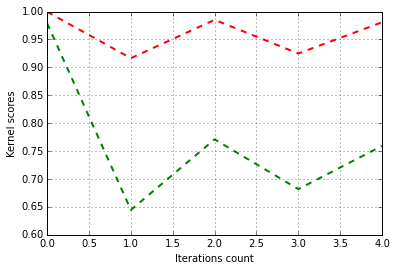

In [26]:
plt.plot(xrange(new_model.num_phi_updates), new_model.scores_info['TopicKernelScore'].average_contrast, 'g--',
         xrange(new_model.num_phi_updates), new_model.scores_info['TopicKernelScore'].average_purity, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('Kernel scores')
plt.grid(True)
plt.show()

Как мы видим, дальнейшее обучение загруженной модели только ухудшило её качество.

Также можно посмотреть на ифнормацию о ядрах каждой темы. Для примера выведем все ядровые слова первой темы:

In [27]:
print new_model.scores_info['TopicKernelScore'].last_topic_info[new_model.topic_names[0]].tokens

[u'allowed', u'award', u'baseball', u'blogads', u'bloggers', u'blogging', u'blogosphere', u'blogs', u'boat', u'book', u'boston', u'bronze', u'curious', u'dailykos', u'drudge', u'drum', u'editors', u'fans', u'franken', u'fun', u'ideological', u'journalism', u'journalists', u'kevin', u'launch', u'limbaugh', u'links', u'lying', u'magazine', u'nevada', u'nyc', u'oreilly', u'owner', u'park', u'petraeus', u'posters', u'propaganda', u'putting', u'reader', u'readers', u'review', u'rewards', u'rnc', u'road', u'rowland', u'rush', u'season', u'selection', u'series', u'sox', u'star', u'starting', u'stations', u'suddenly', u'swift', u'treatment', u'trip', u'universe', u'updates', u'whos', u'writes', u'yankees']


Если у нас есть батч с документами, который не являлся частью обучающей выборки (или являлся, но мы не сохраняли Тету для экономии памяти), и мы хотим узнать столбцы матрицы Теты для него, то следует использовать метод 'find_theta':

In [28]:
test_theta_matrix = model.find_theta(data_path='kos_test', batches=['test_docs.batch'])

ArtmModel.find_theta(), как и ArtmModel.get_theta(), возвращает Тету в виде объекта pandas.DataFrame. Напечатаем ее:

In [29]:
print test_theta_matrix

               3001          3002          3003          3004      3005  \
@topic_0   0.000027  5.470489e-12  8.858154e-05  3.656309e-08  0.023009   
@topic_1   0.000000  7.541699e-08  5.074051e-08  2.938045e-05  0.000895   
@topic_2   0.157189  3.943506e-02  9.634718e-02  3.531554e-02  0.000529   
@topic_3   0.026739  1.165693e-02  1.995720e-04  6.939135e-03  0.000309   
@topic_4   0.042745  6.324435e-01  7.173850e-03  5.326908e-01  0.501921   
@topic_5   0.116399  1.229168e-02  8.142457e-02  2.659782e-01  0.069237   
@topic_6   0.376137  5.741606e-02  1.048807e-01  5.601984e-03  0.097928   
@topic_7   0.163308  1.563603e-01  1.076513e-05  6.481620e-05  0.000017   
@topic_8   0.002778  3.925599e-08  5.331547e-03  2.455403e-03  0.003307   
@topic_9   0.000794  1.425130e-03  8.679743e-03  1.836380e-02  0.000393   
@topic_10  0.031546  4.864770e-04  6.822578e-01  9.276247e-02  0.158374   
@topic_11  0.010005  2.928978e-02  4.955504e-04  1.317876e-02  0.106795   
@topic_12  0.000001  1.54